In [2065]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2066]:
test_results = pd.read_csv('A_B_testing_banner.csv')
test_results.head()

,id,country,gender,group,join_dt,purch_dt,spent,device
0,1000000,CAN,M,B,2023-01-28,NaN,NaN,I
1,1000001,BRA,M,A,2023-01-27,NaN,NaN,A
2,1000002,FRA,M,A,2023-02-01,NaN,NaN,A
3,1000003,BRA,M,B,2023-01-25,NaN,NaN,I
4,1000004,DEU,F,A,2023-02-04,NaN,NaN,A


# Data exploration and cleaning

In [2067]:
# Dataframe size
test_results.shape

(49082, 8)

In [2068]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49082 entries, 0 to 49081
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        49082 non-null  int64  
 1   country   48435 non-null  object 
 2   gender    42200 non-null  object 
 3   group     49082 non-null  object 
 4   join_dt   49082 non-null  object 
 5   purch_dt  2233 non-null   object 
 6   spent     2233 non-null   float64
 7   device    48787 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 3.0+ MB


In [2069]:
# Replacing null values with zeros 
test_results = test_results.fillna(0)
test_results.head()

,id,country,gender,group,join_dt,purch_dt,spent,device
0,1000000,CAN,M,B,2023-01-28,0,0.0,I
1,1000001,BRA,M,A,2023-01-27,0,0.0,A
2,1000002,FRA,M,A,2023-02-01,0,0.0,A
3,1000003,BRA,M,B,2023-01-25,0,0.0,I
4,1000004,DEU,F,A,2023-02-04,0,0.0,A


In [2070]:
#Number of unique users
test_results.id.nunique()

48943

In [2071]:
#Number of unique users in each group
users = test_results.groupby(by=['group'], as_index=False)['id'].nunique()
users

,group,id
0,A,24343
1,B,24600


In [2072]:
#Duration of the test

from datetime import datetime

#Create a df with just the purchse records

df_purch_dates = test_results[test_results['purch_dt'] != 0]

# Find the first and the last day of the test
fist_day = datetime.strptime(test_results['join_dt'].min(), "%Y-%m-%d")
last_day = datetime.strptime(df_purch_dates['purch_dt'].max(), "%Y-%m-%d")

# difference between dates in timedelta

delta = last_day - fist_day
print(f'Difference is {delta.days} days')

print(fist_day, last_day)


Difference is 12 days
2023-01-25 00:00:00 2023-02-06 00:00:00


In [2073]:
#Cast the date columns from strings to date types

test_results['join_dt'] = pd.to_datetime(test_results['join_dt'], format="%Y-%m-%d")
test_results['purch_dt'] = pd.to_datetime(test_results['purch_dt'], format="%Y-%m-%d")

first_day = test_results['join_dt'].min()
last_day = test_results['purch_dt'].max()

delta = last_day - fist_day
print(f'The A/B testing lasted {delta.days} days. The fisrt day was {first_day} and the last day was {last_day}')


The A/B testing lasted 12 days. The fisrt day was 2023-01-25 00:00:00 and the last day was 2023-02-06 00:00:00


<AxesSubplot:xlabel='join_dt,group'>

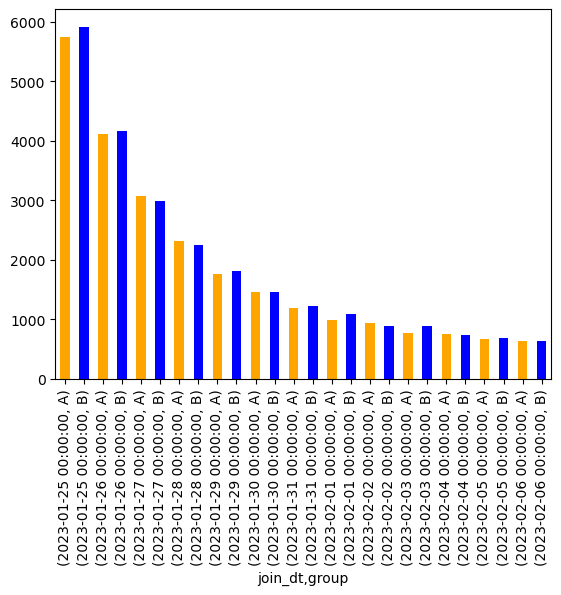

In [2074]:
#Number of users that join the experiment per day 
test_results.groupby(['join_dt', 'group']).count()['id'].plot(kind='bar', color=['orange', 'b'])

<AxesSubplot:xlabel='purch_dt,group'>

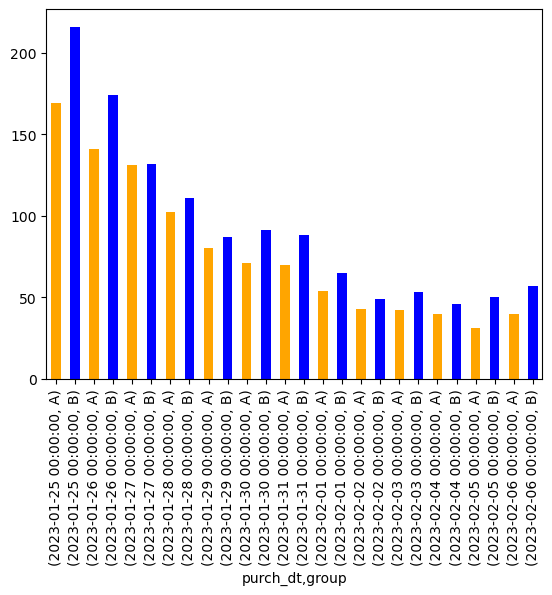

In [2075]:
#Number of users that purchased each day 
df = test_results[test_results['purch_dt'] >= test_results['join_dt']] 
df.groupby(['purch_dt', 'group']).count()['id'].plot(kind='bar', color=['orange', 'b'])

<AxesSubplot:xlabel='purch_dt,group'>

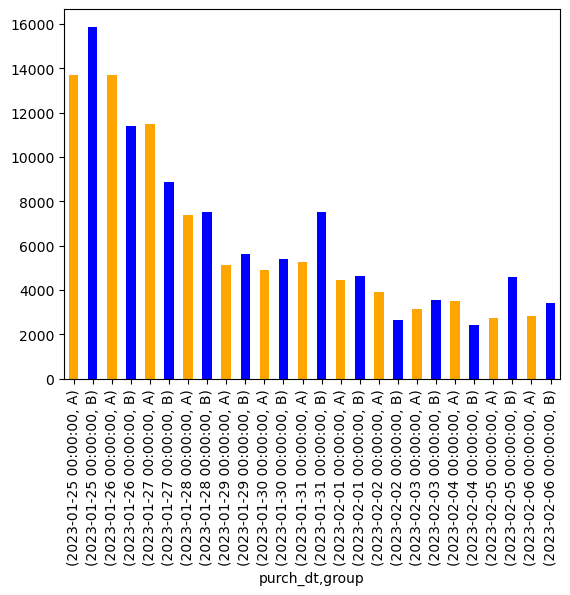

In [2076]:
#Total revenue per day
df = test_results[test_results['purch_dt'] >= test_results['join_dt']] 
df.groupby(['purch_dt', 'group']).sum()['spent'].plot(kind='bar', color=['orange', 'b'])

In [2077]:
# Include a column for the diference between a purchase date and the date the user joined the test

test_results['days_to_purchase'] = test_results['purch_dt'] - test_results['join_dt']
df = test_results[test_results['purch_dt'] >= test_results['join_dt']] 

#Count the number of users that made a purchase x days after joining the test

df = df.groupby('days_to_purchase').count()['id']
df

days_to_purchase
0 days    1648
1 days     160
2 days     117
3 days     114
4 days      94
5 days      73
6 days      27
Name: id, dtype: int64

[Text(0, 0, '0 days'),
 Text(1, 0, '1 days'),
 Text(2, 0, '2 days'),
 Text(3, 0, '3 days'),
 Text(4, 0, '4 days'),
 Text(5, 0, '5 days'),
 Text(6, 0, '6 days')]

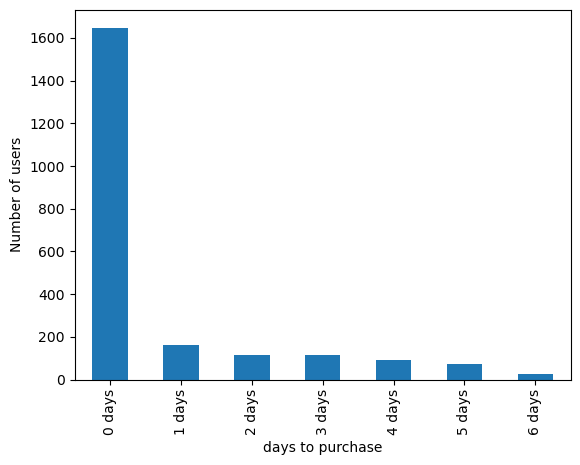

In [2078]:
fig, ax = plt.subplots()

df.plot(kind='bar')
plt.ylabel('Number of users')
plt.xlabel('days to purchase')

ax.set_xticklabels(['0 days', '1 days', '2 days', '3 days', '4 days', '5 days', '6 days'])


In [2079]:
#Which were the users that bought more than once?
purchases = test_results.groupby('id')['purch_dt'].count()
purchases[purchases>1]

id
1000101    2
1001185    2
1001500    2
1001855    2
1002664    2
          ..
1048302    2
1048763    2
1049191    2
1049616    2
1049747    2
Name: purch_dt, Length: 139, dtype: int64

# Were the groups randomly selected?

In [2080]:
#Extracting demographic data to prove randomness
countries = test_results.groupby(['country', 'group'])['id'].count()
countries

country  group
0        A         299
         B         348
AUS      A         608
         B         560
BRA      A        4818
         B        4635
CAN      A         770
         B         803
DEU      A        1912
         B        1958
ESP      A         997
         B        1003
FRA      A        1539
         B        1558
GBR      A        1457
         B        1501
MEX      A        2820
         B        2934
TUR      A        1852
         B        1889
USA      A        7330
         B        7491
Name: id, dtype: int64

In [2081]:
genders = test_results.groupby(['gender', 'group'])['id'].count()
genders

gender  group
0       A         3420
        B         3462
F       A        10104
        B        10096
M       A        10069
        B        10258
O       A          809
        B          864
Name: id, dtype: int64

In [2082]:
devices = test_results.groupby(['device', 'group'])['id'].count()
devices

device  group
0       A          147
        B          148
A       A        15081
        B        15274
I       A         9174
        B         9258
Name: id, dtype: int64

In [2083]:
# As the columns country, gender, and device have values that do not make sense like 0 and O its better hide them to graph

clean_df = test_results[test_results["gender"]!= "O"]
clean_df = clean_df[clean_df["gender"] != 0]
clean_df = clean_df[clean_df["device"] != 0]
clean_df = clean_df[clean_df["country"] != 0]


In [2084]:
#General pivot table
demo = pd.pivot_table(clean_df, values="id", index=["country", "device", "gender"], columns=["group"], aggfunc='count')
demo.head(10)

group                     A     B
country device gender            
AUS     A      F        174   134
               M        150   134
        I      F         89    86
               M         93    99
BRA     A      F       1208  1145
               M       1249  1208
        I      F        759   705
               M        726   772
CAN     A      F        186   216
               M        204   185

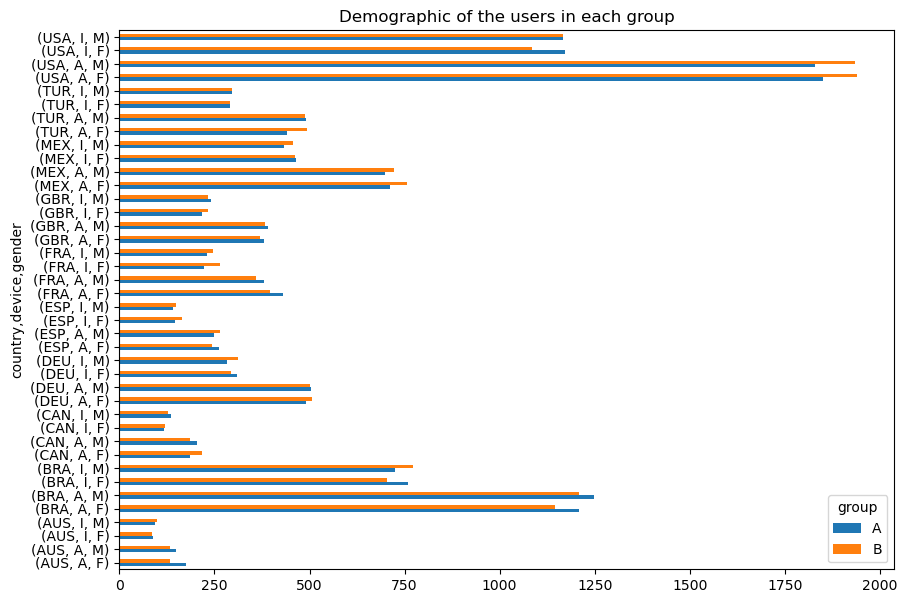

In [2085]:
demo.plot.barh(figsize=(10,7), title="Demographic of the users in each group")

plt.show()

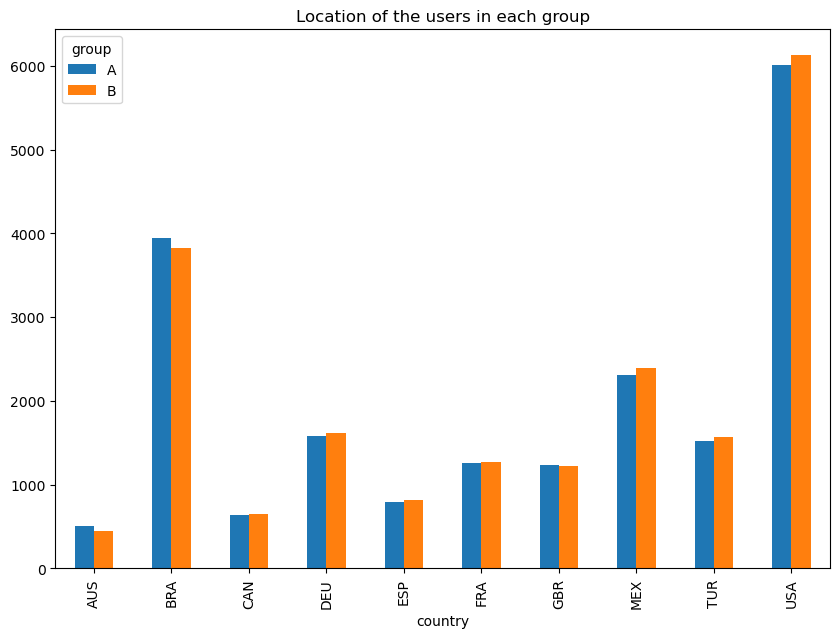

In [2086]:
#The previous bar plot contains too much information. Lets split this plot to better understanding. 
demo = pd.pivot_table(clean_df, values="id", index=["country"], columns=["group"], aggfunc='count')
demo.plot.bar(figsize=(10,7), title="Location of the users in each group")

plt.savefig('Loc_users.png')
plt.show()

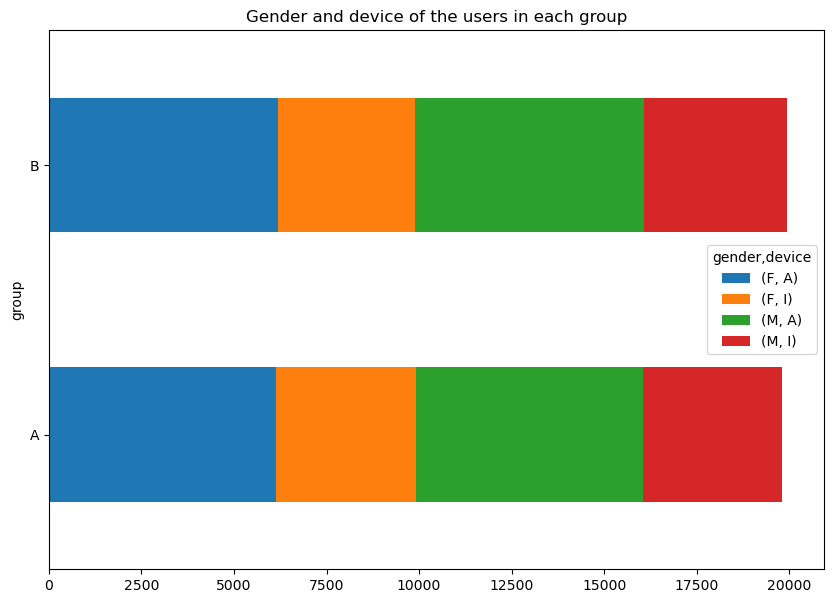

In [2087]:
demo = pd.pivot_table(clean_df, values="id", index=["group"], columns=["gender", "device"], aggfunc='count')
demo.plot.barh(figsize=(10,7), title="Gender and device of the users in each group", stacked=True)

plt.savefig('gender_device.png')
plt.show()

The A/B test was run using the adequated stratified random sampling. 

# Performing a t-test with the revenue 

In [2088]:
# Splitting the groups and filtering by spent 

revenue_control = test_results.query('spent != 0 and group == "A"')
revenue_test = test_results.query('spent != 0 and group == "B"')

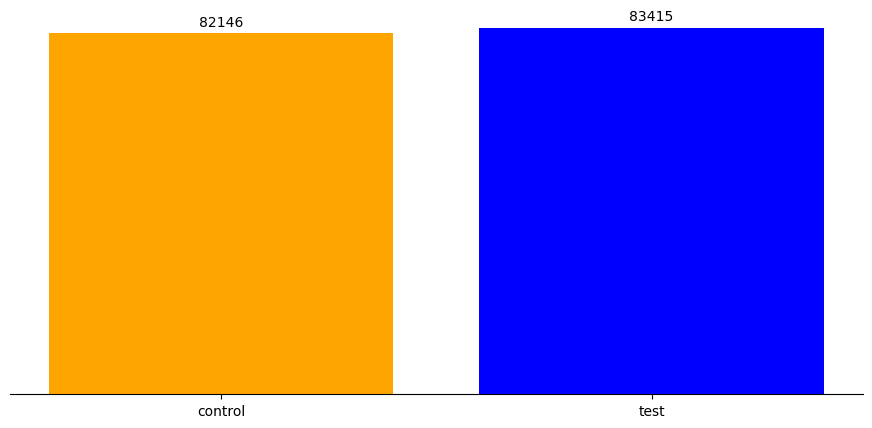

In [2089]:
# Showing the total revenue per group 

fig, ax = plt.subplots(figsize = (11, 5))

rev_control = revenue_control['spent'].sum()
rev_test = revenue_test['spent'].sum()

bars = ax.bar(['control','test'], height = [rev_control, rev_test], color = ['orange', 'b'])

# Including annotations in the bars
for bar in bars:
   height = round(bar.get_height())
   ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
   textcoords="offset points", ha='center', va='bottom')

# Remove the y axe
ax.yaxis.set_visible(False)

#Remove the frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.show()


In [2090]:
# Calculating the variences of each group

sa = revenue_control['spent'].std()**2
sb = revenue_test['spent'].std()**2
print(sa, sb)

9203.696389346633 7999.686633093391


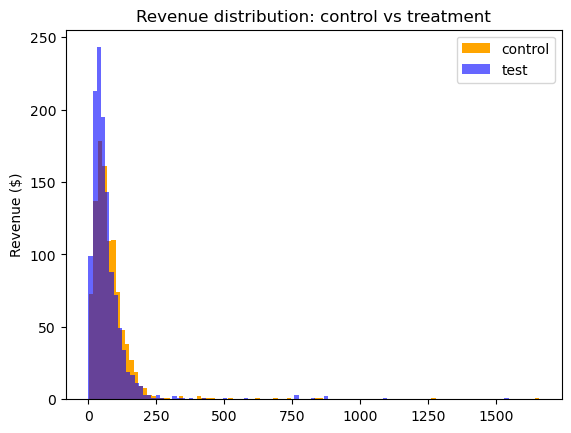

In [2091]:
# Observing the distribution of revenue in each group

plt.hist(revenue_control['spent'], bins=100, label = 'control', color = 'orange')
plt.hist(revenue_test['spent'], bins=100, alpha = 0.6, label = 'test', color='b')
plt.legend()
plt.ylabel("Revenue ($)")
plt.title("Revenue distribution: control vs treatment")

plt.savefig('Revenue_distr.png')
plt.show()

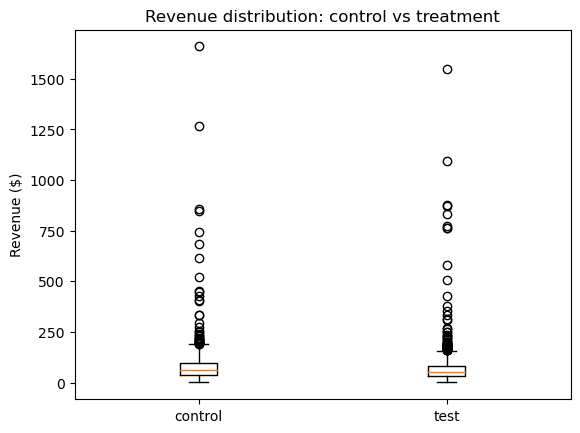

In [2092]:
# To better visualise the outliers do box plots

fig, ax = plt.subplots()

plt.boxplot([revenue_control['spent'], revenue_test['spent']])

ax.set_xticklabels(['control', 'test'])

plt.ylabel("Revenue ($)")
plt.title("Revenue distribution: control vs treatment")

plt.savefig('Revenue_barplot.png')
plt.show()

According to the previous box-plots the revenue has many outliers wich lead to high variances and the difference between means is more likely to be due to random error.


#  Performing a z-test for the revenue per user

In [2093]:
# Extracting the column 'spent' with unique users from every group

rev_cont = pd.pivot_table(test_results[test_results.group == 'A'], values='spent', index=['group', 'id'], aggfunc=np.sum)
rev_cont = np.array(rev_cont[['spent']])

rev_treat = pd.pivot_table(test_results[test_results.group == 'B'], values='spent', index=['group', 'id'], aggfunc=np.sum)
rev_treat = np.array(rev_treat[['spent']])

print('The average spent by the control group was ${}'.format(rev_cont.mean()))
print('The average spent by the test group was ${}'.format(rev_treat.mean()))

The average spent by the control group was $3.374518467928841
The average spent by the test group was $3.390866945885783


# Calculate the confidence interval for the control group 


In [2094]:
# Import scipy and the t-test method
from scipy import stats
from scipy.stats import t
m_cont = rev_cont.mean() 
sd_cont = rev_cont.std() 
dof = len(x)-1 
confidence = 0.95

In [2095]:
# First calculate the t value

z = 1.96 # for a 95% confidence interval

# Confidence interval

ci = (m_cont-z*sd_cont/np.sqrt(len(rev_cont)), m_cont+z*sd_cont/np.sqrt(len(rev_cont)))

print('The confidence interval for the control group is: {}'.format(ci))

The confidence interval for the control group is: (3.0487045452841404, 3.700332390573542)


# Calculate the confidence interval for the treatment using a t-test

In [2096]:
m_treat = rev_treat.mean() 
sd_treat = rev_treat.std() 
dof = len(y)-1 
confidence = 0.95

z = 1.96

ci2 = (m_treat-z*sd_treat/np.sqrt(len(rev_treat)), m_treat+z*sd_treat/np.sqrt(len(rev_treat)))

print('The confidence interval for the treatment group is: {}'.format(ci2))

The confidence interval for the treatment group is: (3.073285889493473, 3.708448002278093)


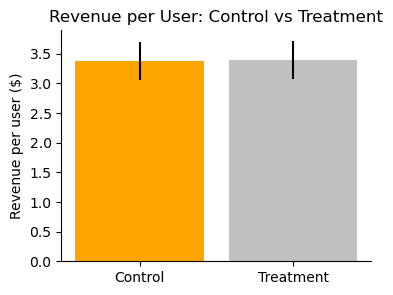

In [2097]:
# Plotting the average revenue per group 


# Calculating the distance in confidence intervals
yerr_cont = (ci[1]-ci[0])/2
yerr_test = (ci2[1]-ci2[0])/2

# labels
tick_labels = ['Control','Treatment']

#Reduce the space between bars
w = 0.2
y_pos = (w/2.,w*1.7)

fig, ax = plt.subplots(figsize = (4, 3))

bars = ax.bar(y_pos, height = [rev_cont.mean(), rev_treat.mean()], color = ['orange', 'silver'], width= w, yerr = [yerr_cont, yerr_test])

# Put the labels in the ticks 
plt.xticks(y_pos, tick_labels)

plt.ylabel("Revenue per user ($)")

plt.title('Revenue per User: Control vs Treatment')

#Remove frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('Avg_revenues.png')
plt.show()



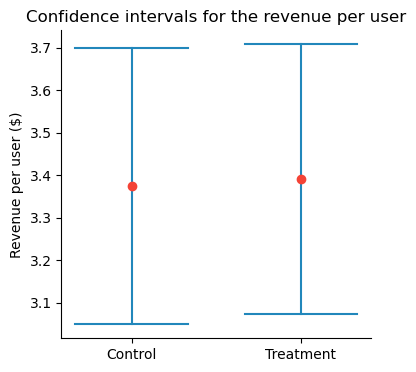

In [2098]:
conf_interval_control = (ci[1]-ci[0])/2
conf_interval_test = (ci2[1]-ci2[0])/2

rev_cont_mean = rev_cont.mean()
rev_treat_mean = rev_treat.mean()

fig, ax = plt.subplots(figsize=(4,4))

def plot_confidence_interval(x, rev, conf_interval, color='#2187bb', horizontal_line_width=0.2):

    left = x - horizontal_line_width / 3
    top = rev - conf_interval
    right = x + horizontal_line_width / 3
    bottom = rev + conf_interval
    ax.plot([x, x], [top, bottom], color=color)
    ax.plot([left, right], [top, top], color=color)
    ax.plot([left, right], [bottom, bottom], color=color)
    ax.plot(x, rev, 'o', color='#f44336')

    return rev, conf_interval


plt.xticks([1, 1.2], ['Control', 'Treatment'])
plt.title('Confidence intervals for the revenue per user')
plot_confidence_interval(1, rev_cont_mean, conf_interval_control)
plot_confidence_interval(1.2, rev_treat_mean, conf_interval_test)

#Remove frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel("Revenue per user ($)")

plt.savefig('Conf_intervals_rev.png')

plt.show()

# Hypothesis test for the difference of means 

In [2099]:
#Conduct a hypothesis test to see whether there is a difference in the average amount spent per user between the two groups

# Ho: mean(test) - mean(control) = 0  Ha: mean(test) - mean(control) != 0

# Get the number of users in each group 

na = len(rev_cont)
nb = len(rev_treat)
print('Number of user in the control group: {}'.format(na))
print('Number of user in the control group: {}'.format(nb))

#means and std deviations

ma = rev_cont.mean()
mb = rev_treat.mean()
sda = rev_cont.std()
sdb = rev_treat.std()

# calculate the difference of means

means_d = mb - ma

# Calculate the unpooled standard error 
se_pool = np.sqrt(sda ** 2 / na + sdb ** 2 / nb)


#confidence interval 

low = means_d - 1.96*se_pool  #lower limit of the CI
upp = means_d + 1.96*se_pool  #upper limit of the CI

low, upp


Number of user in the control group: 24343
Number of user in the control group: 24600


(-0.4386377191615888, 0.47133467507547244)

In [2100]:
#calculate the p value 

lift = -abs(means_d)
p_value = 2*stats.norm.cdf(lift, loc=0, scale = se_pool)

# Print the p_value

print('p-value = {}'.format(p_value))

p-value = 0.9438543196901168


We can not reject the null hypothesis. The difference of means is no statistically significant.

# Conversion Rates


In [2101]:
users

,group,id
0,A,24343
1,B,24600


In [2102]:
#Calculate the number of unique users that meade a purchase at least once
sales = test_results.query('purch_dt >= join_dt')
n_conversions = sales.groupby(by=['group'], as_index=False)['id'].nunique()
n_conversions

,group,id
0,A,955
1,B,1139


In [2103]:
control_cr = n_conversions.iloc[0,1]/users.iloc[0,1]
test_cr = n_conversions.iloc[1,1]/users.iloc[1,1]

print('The convesion rate of the control group is {}'.format(control_cr))
print('The convesion rate of the test group is {}'.format(test_cr))

The convesion rate of the control group is 0.03923099042845993
The convesion rate of the test group is 0.04630081300813008


In [2104]:
#Confidence interval for the control

import statsmodels.api as sm

# Function for computing confidence intervals
from statsmodels.stats.proportion import proportion_confint   

ci = proportion_confint(count=n_conversions.iloc[0,1],    # Number of "successes"
                   nobs=users.iloc[0,1],    # Number of trials
                   alpha=(1 - 0.95))  # Alpha, which is 1 minus the confidence level

print('Confidence interval for the control group = {}'.format(ci))


Confidence interval for the control group = (0.036792139975547034, 0.04166984088137282)


In [2105]:
#Confidence interval for the treatment group

# Function for computing confidence intervals 

ci2 = proportion_confint(count=n_conversions.iloc[1,1],    # Number of "successes"
                   nobs=users.iloc[1,1],    # Number of trials
                   alpha=(1 - 0.95))

print('Confidence interval for the test group = {}'.format(ci2))

Confidence interval for the test group = (0.043674898684431224, 0.04892672733182894)


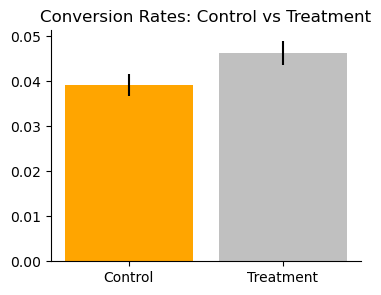

In [2106]:
# Showing the conversion rate with confidence intervals 

# Calculating the distance in confidence intervals
yerr_cont = (ci[1]-ci[0])/2
yerr_test = (ci2[1]-ci2[0])/2

# labels
tick_labels = ['Control','Treatment']

#Reduce the space between bars
w = 0.2
y_pos = (w/2.,w*1.7)

fig, ax = plt.subplots(figsize = (4, 3))

bars = ax.bar(y_pos, height = [control_cr, test_cr], color = ['orange', 'silver'], width= w, yerr = [yerr_cont, yerr_test])

# Put the labels in the ticks 
plt.xticks(y_pos, tick_labels)

#Remove frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.title('Conversion Rates and Confidence Intervals')
plt.title('Conversion Rates: Control vs Treatment')

plt.savefig('Conversion_rates.png')

plt.show()

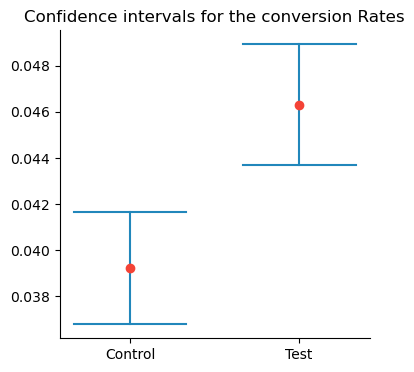

In [2107]:

conf_interval_control = (ci[1]-ci[0])/2
conf_interval_test = (ci2[1]-ci2[0])/2

fig, ax = plt.subplots(figsize=(4,4))

def plot_confidence_interval(x, cr, conf_interval, color='#2187bb', horizontal_line_width=0.2):

    left = x - horizontal_line_width / 3
    top = cr - conf_interval
    right = x + horizontal_line_width / 3
    bottom = cr + conf_interval
    ax.plot([x, x], [top, bottom], color=color)
    ax.plot([left, right], [top, top], color=color)
    ax.plot([left, right], [bottom, bottom], color=color)
    ax.plot(x, cr, 'o', color='#f44336')

    return cr, conf_interval


plt.xticks([1, 1.2], ['Control', 'Test'])
#plt.title('Conversion Rates and Confidence Intervals')
plt.title('Confidence intervals for the conversion Rates')
plot_confidence_interval(1, control_cr, conf_interval_control)
plot_confidence_interval(1.2, test_cr, conf_interval_test)

#Remove frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('Conf_intervals.png')

plt.show()

# Plotting the distributions

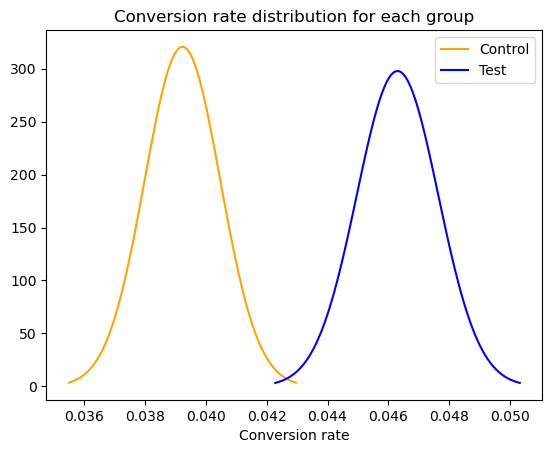

In [2108]:
from scipy.stats import norm

line_control = np.linspace(-3*control_var**0.5+control_cr, 3*control_var**0.5+control_cr, 100)
line_test = np.linspace(-3*test_var**0.5+test_cr, 3*test_var**0.5+test_cr, 100)

plt.plot(line_control, norm.pdf(line_control, control_cr, control_var**0.5), label='Control', color = 'orange')
plt.plot(line_test, norm.pdf(line_test, test_cr, test_var**0.5), label='Test', color = 'blue')
plt.legend()
plt.xlabel('Conversion rate')
plt.title("Conversion rate distribution for each group")

plt.savefig('Norm_Cr_Tr.png')
plt.show()

# Hypothesis testing for the difference between conversion rates

In [2109]:
#Calculate the p value 

# Ho : control_cr - test_cr == 0  Ha: Ho : control_cr - test_cr != 0 

from scipy import stats


def get_pvalue(control_cr, test_cr, n_control, n_test):  
    lift =  - abs(test_cr - control_cr)

    se_cont = control_cr * (1 - control_cr) * (1 / n_control)
    se_treat = test_cr * (1 - test_cr) * (1 / n_test)
    se_d = (se_cont + se_treat)**0.5

    p_value = 2 * stats.norm.cdf(lift, loc = 0, scale = se_d )
    
    if p_value >= 0.01:
        print("Not Significant")
    else:
        print("Significant Result")
        
    return p_value

p_value = get_pvalue(control_cr, test_cr, n_control, n_test)
print(p_value)

Significant Result
0.00011041535190456046


# Confidence interval for the diference of convesion rates

In [2110]:
def get_ci(control_cr, test_cr, n_control, n_test, cl):
    lift =  test_cr - control_cr
    
    sd = (control_cr * (1 - control_cr)/ n_control + test_cr * (1 - test_cr)/ n_test)**0.5
    
    val = stats.norm.isf((1-cl)/2)
    
    lwr_bnd = lift - val*sd
    upr_bnd = lift + val*sd
 
    return((lwr_bnd, upr_bnd))

In [2111]:
ci = get_ci(control_cr, test_cr, n_control, n_test, 0.95)
print('Confidence interval for the diference = {}'.format(ci))

Confidence interval for the diference = (0.0034860511629807105, 0.0106535939963596)


# Plotting the distribution for the difference of conversion rates

In [2112]:
#Generate a range of values with a distribution +- 3 sd from the mean

control_var = control_cr * (1 - control_cr) * (1 / n_control)
test_var = test_cr * (1 - test_cr) * (1 / n_test)

print(control_cr, control_var**0.5)
print(test_cr, test_var**0.5)


0.03923099042845993 0.001244334320502947
0.04630081300813008 0.0013397768246823593


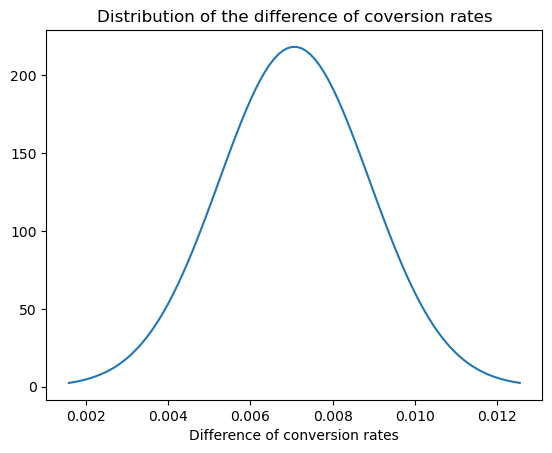

In [2113]:
lift =  test_cr - control_cr
var = control_var + test_var

diff_line = np.linspace(-3*var**0.5+lift, 3*var**0.5+lift, 100)

plt.plot(diff_line, norm.pdf(diff_line, lift, var**0.5))
plt.xlabel('Difference of conversion rates')
plt.title("Distribution of the difference of coversion rates")

plt.savefig('Diff_Norm_distr.png')
plt.show()

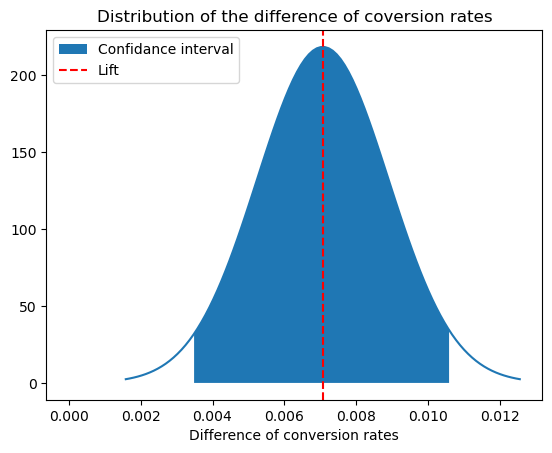

In [2114]:
#Find values over the confidence interval
section = np.arange(ci[0], ci[1], 1/10000)

#Fill in the curve between those values

plt.fill_between(section, norm.pdf(section, lift, var**0.5), label = 'Confidance interval')

# Plot the difference curve with the confidence interval 

plt.plot(diff_line, norm.pdf(diff_line, lift, var**0.5))
plt.plot(0.008)
plt.axvline(x = lift, color = 'r', linestyle = '--', label = 'Lift')
plt.legend()
plt.xlabel('Difference of conversion rates')

plt.title("Distribution of the difference of coversion rates")
plt.savefig('Diff_distr_CI.png')
plt.show()


# Practical significance 

In [2115]:
#Percentual difference in conversion rates
(test_cr - control_cr)/control_cr

0.1802101477035713

In [2116]:
# Cohen's d or Hedges' 

#correct if the population S.D. is expected to be equal for the two groups.

# Pooled standard deviation

control_var = control_cr * (1 - control_cr) * (1 / n_control)
test_var = test_cr * (1 - test_cr) * (1 / n_test)

sd_pooled = (((n_control - 1)*control_var + (n_test -1)*test_var)/(n_control+n_test-2))**0.5

# Difference of the means

lift

# Cohen's d

cohens_d = lift / sd_pooled

print(f"Cohen's d = {cohens_d:.3f}")



Cohen's d = 5.467


It looks like the test also has practical significance.